In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'two_body_2'

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
M = 10
orbit_timesteps = 1000
orbit_duration = 100

In [5]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':['bar'],
                'stationary_potential_kwargs_list':[{'M':1e10, 'a':5000, 'b':1500, 'c':1000, 'omega_p':0.04}],
                # 'stationary_potential_list':['point_source'],
                # 'stationary_potential_kwargs_list':[{'M':1e10}],
                'dynamic_potential_list':['tracer','tracer'],
                'dynamic_potential_kwargs_list':[{'M':0}, {'M':0}],
                'seed':seed,
                'box_scaling':1000,
                'orbit_duration':orbit_duration,
                'orbit_timesteps':orbit_timesteps
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()
env.reset()
def plot_from_init(init_params):
    env.reset()
    init_params = {key:value/env.high for key,value in init_params.items()}
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    # orbit_delta = info['orbit_delta']
    # reverse_orbit_init_params = orbit.y[:,-1]
    # reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    # reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    # reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        # ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax1.scatter(0,0,0)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        # ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')
    ax2.scatter(0,0)

    # ax3 = fig.add_subplot(133)
    # ax3.plot(orbit.y[0])
    # # ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    # # ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    # print(orbit.y)
    # ax1.legend()
    # ax2.legend()
    # ax3.legend()
    return orbit

[ENV] Using cpu
[ENV] Seed set to 0


In [6]:
# results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
# result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
# result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
# fig = plt.figure(figsize=(16, 8))
# ax1 = fig.add_subplot(121, projection='3d')
# for agent in range(env.num_agents):
#     ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.legend()
# ax1.set_title('Initial positions studied')

# ax2 = fig.add_subplot(122)
# for agent in range(env.num_agents):
#     ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')
# ax2.legend()
# ax2.set_title('Initial positions studied, projected on the XY plane')

In [7]:
# env.stationary_potentials[0].get_acceleration(np.array([3000,300,200,0]))
# env.stationary_potentials[0].get_acceleration(np.array([3000,-300,200,0]))

In [8]:
# fig = plt.figure(figsize=(24, 12))
# ax1 = fig.add_subplot(121, projection='3d')
# X = np.linspace(-10000,10000,25)
# x, y, z = np.meshgrid(X, X, X)
# k=12
# xs, ys, zs, cs = [], [], [], []
# for i in range(len(x)):
#     for j in range(len(x)):
#         xs.append(x[i][j][k])
#         ys.append(y[i][j][k])
#         zs.append(z[i][j][k])
#         cs.append(np.sum(env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))))
# im = ax1.scatter(xs,ys,zs,c=cs,cmap='viridis')
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.set_title('Initial positions studied')

In [9]:
# fig = plt.figure(figsize=(24, 12))
# ax1 = fig.add_subplot(121, projection='3d')
# X = np.linspace(-10000,10000,25)
# x, y, z = np.meshgrid(X, X, X)
# k=11
# xs, ys, zs, cs = [], [], [], []
# for i in range(len(x)):
#     for j in range(len(x)):
#         xs.append(x[i][j][k])
#         ys.append(y[i][j][k])
#         zs.append(z[i][j][k])
#         cs.append(np.sum(env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))))
# im = ax1.scatter(xs,ys,zs,c=cs,cmap='viridis')
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.set_title('Initial positions studied')

In [10]:
# fig = plt.figure(figsize=(24, 12))
# ax1 = fig.add_subplot(121, projection='3d')
# X = np.linspace(-10000,10000,25)
# x, y, z = np.meshgrid(X, X, X)
# k=13
# xs, ys, zs, cs = [], [], [], []
# for i in range(len(x)):
#     for j in range(len(x)):
#         xs.append(x[i][j][k])
#         ys.append(y[i][j][k])
#         zs.append(z[i][j][k])
#         cs.append(np.sum(env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))))
# im = ax1.scatter(xs,ys,zs,c=cs,cmap='viridis')
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.set_title('Initial positions studied')

In [11]:
# print(env.stationary_potentials[0].get_acceleration(np.array([1,0,0,0])))
# print(env.stationary_potentials[0].get_acceleration(np.array([0,1,0,0])))
# print(env.stationary_potentials[0].get_acceleration(np.array([0,0,1,0])))

In [12]:
# def result_to_init(i):
#     return {agent:result_init_params[agent][:,i] for agent in range(env.num_agents)}

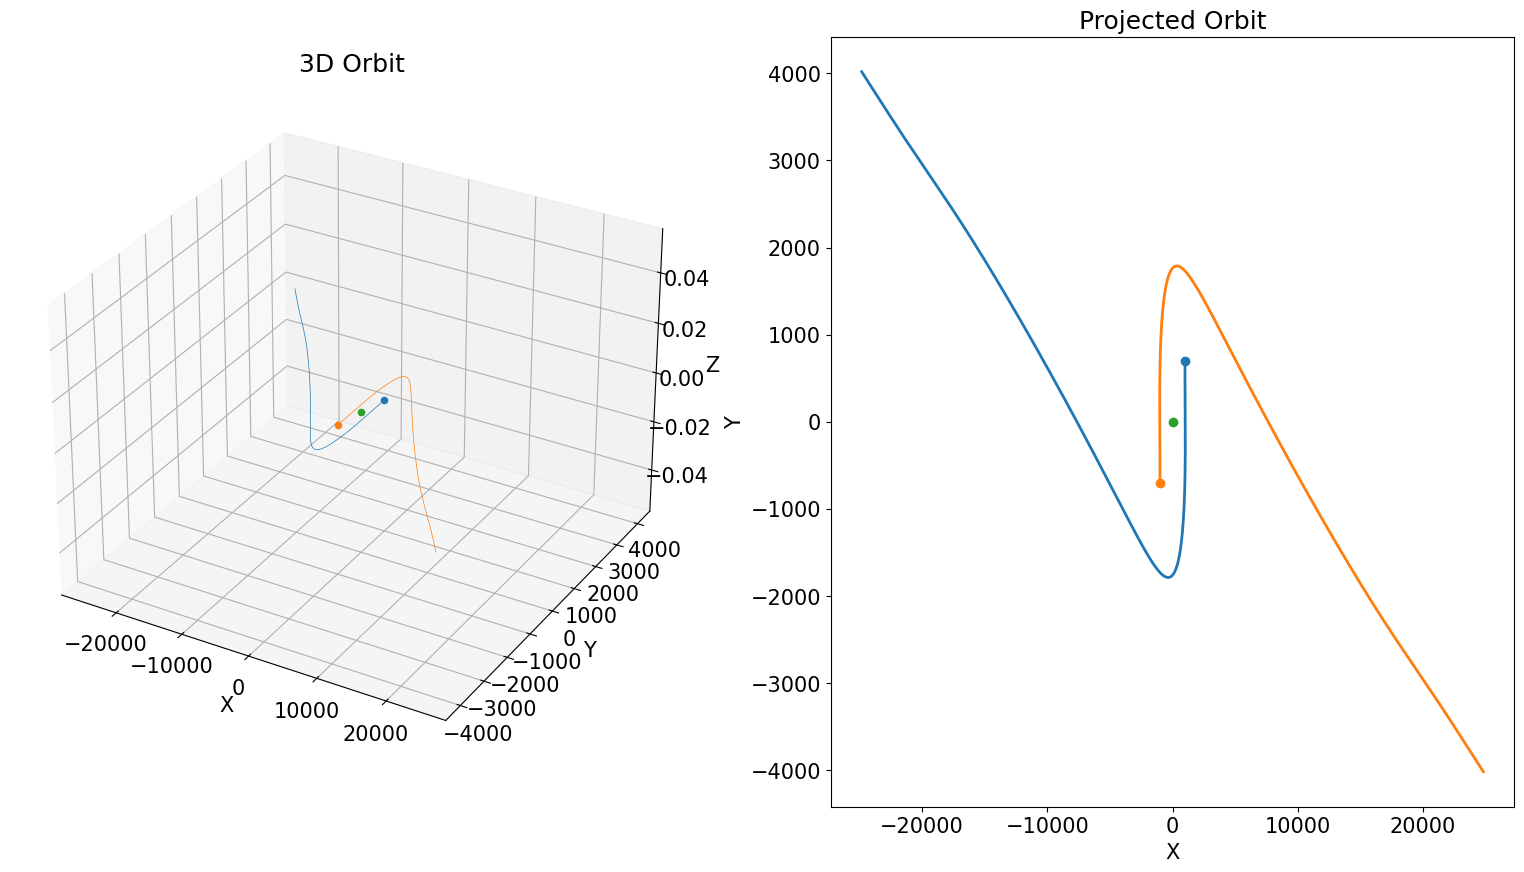

In [13]:
init_params = {0:np.array([1000,700,0,0,0,0]), 1:np.array([-1000,-700,0,0,0,0])}
orbit = plot_from_init(init_params)

In [14]:
a1 = env.stationary_potentials[0].get_acceleration(np.array([999.99661164,699.91215373,0,0]))
a2 = env.stationary_potentials[0].get_acceleration(np.array([-999.99661164,699.91215373,0,0]))
print(a1)
print(a2)
print(np.array(a1)-np.array(a2))

(array([-2.62962733]), array([-68.16719875]), array([0.]))
(array([2.62962733]), array([-68.16719875]), array([0.]))
[[-5.25925467]
 [ 0.        ]
 [ 0.        ]]


In [15]:
def leapfrog_verlet_step(ode_function, y0):
    delta_t = orbit_duration / orbit_timesteps
    pos, vel = y0[:3], y0[3:]
    acc = np.array(ode_function(np.array(pos.tolist()+[0])))
    v_half = vel + 0.5 * delta_t * acc.flatten()
    pos_i = pos + delta_t * v_half
    new_acc = np.array(ode_function(np.array(pos_i.tolist()+[0])))
    vel_i = v_half + 0.5 * delta_t * new_acc.flatten()
    acc = new_acc
    print(pos, 'pos')
    print(vel, 'vel')
    print(pos_i, 'pos_i')
    print(vel_i, 'vel_i')
    print(acc, 'acc')
    print(new_acc, 'newacc')

In [16]:
step = 0
c1, c2 = orbit.y[:3,step], orbit.y[6:9,step]
c1, c2 = np.array(c1.tolist()+[0]), np.array(c2.tolist()+[0])
print(c1)
print(c2)
a1 = env.stationary_potentials[0].get_acceleration(c1)
a2 = env.stationary_potentials[0].get_acceleration(c2)
print(a1)
print(a2)
print(np.array(a1) - np.array(a2))

[1000.  700.    0.    0.]
[-1000.  -700.     0.     0.]
(array([-2.62879583]), array([-68.15396602]), array([0.]))
(array([2.62879583]), array([68.15396602]), array([0.]))
[[  -5.25759166]
 [-136.30793204]
 [   0.        ]]


In [17]:
leapfrog_verlet_step(env.stationary_potentials[0].get_acceleration, orbit.y[:6,step])
leapfrog_verlet_step(env.stationary_potentials[0].get_acceleration, orbit.y[6:12,step])

[1000.  700.    0.] pos
[0. 0. 0.] vel
[999.98685602 699.65923017   0.        ] pos_i
[-0.26304095 -6.81796415  0.        ] vel_i
[[ -2.63202324]
 [-68.20531702]
 [  0.        ]] acc
[[ -2.63202324]
 [-68.20531702]
 [  0.        ]] newacc
[-1000.  -700.     0.] pos
[0. 0. 0.] vel
[-999.98685602 -699.65923017    0.        ] pos_i
[0.26304095 6.81796415 0.        ] vel_i
[[ 2.63202324]
 [68.20531702]
 [ 0.        ]] acc
[[ 2.63202324]
 [68.20531702]
 [ 0.        ]] newacc
